In [24]:
from scipy.spatial import distance
import pickle
import torch
from torch import linalg
import numpy as np
from scipy.linalg import cho_solve
from matplotlib import pyplot as plt

In [25]:
"""Gaussian Mixture Model."""

# Author: Wei Xue <xuewei4d@gmail.com>
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import numpy as np
import numbers
from scipy import linalg


def _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar):
    n_components, n_features = means.shape
    covariances = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        diff = X - means[k]
        covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
        covariances[k].flat[:: n_features + 1] += reg_covar
    return covariances


def _estimate_gaussian_covariances_tied(resp, X, nk, means, reg_covar):
    avg_X2 = np.dot(X.T, X)
    avg_means2 = np.dot(nk * means.T, means)
    covariance = avg_X2 - avg_means2
    covariance /= nk.sum()
    covariance.flat[:: len(covariance) + 1] += reg_covar
    return covariance


def _estimate_gaussian_covariances_diag(resp, X, nk, means, reg_covar):
    avg_X2 = np.dot(resp.T, X * X) / nk[:, np.newaxis]
    avg_means2 = means**2
    avg_X_means = means * np.dot(resp.T, X) / nk[:, np.newaxis]
    
    return avg_X2 - 2 * avg_X_means + avg_means2 + reg_covar


def _estimate_gaussian_covariances_spherical(resp, X, nk, means, reg_covar):
    return _estimate_gaussian_covariances_diag(resp, X, nk, means, reg_covar).mean(1)


def _estimate_gaussian_parameters(X, resp, reg_covar, covariance_type):
    nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
    means = np.dot(resp.T, X) / nk[:, np.newaxis]
    covariances = {
        "full": _estimate_gaussian_covariances_full,
        "tied": _estimate_gaussian_covariances_tied,
        "diag": _estimate_gaussian_covariances_diag,
        "spherical": _estimate_gaussian_covariances_spherical,
    }[covariance_type](resp, X, nk, means, reg_covar)
    return nk, means, covariances


def _compute_precision_cholesky(covariances, covariance_type):
    estimate_precision_error_message = (
        "Fitting the mixture model failed because some components have "
        "ill-defined empirical covariance (for instance caused by singleton "
        "or collapsed samples). Try to decrease the number of components, "
        "or increase reg_covar."
    )

    if covariance_type == "full":
        n_components, n_features, _ = covariances.shape
        precisions_chol = np.empty((n_components, n_features, n_features))
        for k, covariance in enumerate(covariances):
            try:
                cov_chol = linalg.cholesky(covariance, lower=True)
            except linalg.LinAlgError:
                raise ValueError(estimate_precision_error_message)
            precisions_chol[k] = linalg.solve_triangular(
                cov_chol, np.eye(n_features), lower=True
            ).T
    elif covariance_type == "tied":
        _, n_features = covariances.shape
        try:
            cov_chol = linalg.cholesky(covariances, lower=True)
        except linalg.LinAlgError:
            raise ValueError(estimate_precision_error_message)
        precisions_chol = linalg.solve_triangular(
            cov_chol, np.eye(n_features), lower=True
        ).T
    else:
        if np.any(np.less_equal(covariances, 0.0)):
            raise ValueError(estimate_precision_error_message)
        precisions_chol = 1.0 / np.sqrt(covariances)
    return precisions_chol


def check_random_state(seed):
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, numbers.Integral):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError(
        "%r cannot be used to seed a numpy.random.RandomState instance" % seed
    )


class GMMInitalisation():

    def __init__(
        self,
        n_components=1,
        *,
        covariance_type="full",
        tol=1e-3,
        reg_covar=-1e-6,
        init_params="random_from_data",
        weights_init=None,
        means_init=None,
        precisions_init=None,

    ):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.init_params = init_params
        self.covariance_type = covariance_type
        self.weights_init = weights_init
        self.means_init = means_init
        self.precisions_init = precisions_init

    def initialize_parameters(self, X, random_state):
        n_samples, _ = X.shape

        if self.init_params == "random":
            resp = random_state.uniform(size=(n_samples, self.n_components))
            resp /= resp.sum(axis=1)[:, np.newaxis]
        elif self.init_params == "random_from_data":
            resp = np.zeros((n_samples, self.n_components))
            indices = random_state.choice(
                n_samples, size=self.n_components, replace=False
            )
            resp[indices, np.arange(self.n_components)] = 1
        else:
            raise ValueError(
                "Unimplemented initialization method '%s'" % self.init_params
            )
        print(resp)
        self._initialize(X, resp)

    def _initialize(self, X, resp):
        n_samples, _ = X.shape

        weights, means, covariances = _estimate_gaussian_parameters(
            X, resp, self.reg_covar, self.covariance_type
        )
        weights /= n_samples

        self.weights_ = weights if self.weights_init is None else self.weights_init
        self.means_ = means if self.means_init is None else self.means_init

        if self.precisions_init is None:
            self.covariances_ = covariances
            self.precisions_cholesky_ = _compute_precision_cholesky(
                covariances, self.covariance_type
            )
        elif self.covariance_type == "full":
            self.precisions_cholesky_ = np.array(
                [
                    linalg.cholesky(prec_init, lower=True)
                    for prec_init in self.precisions_init
                ]
            )
        elif self.covariance_type == "tied":
            self.precisions_cholesky_ = linalg.cholesky(
                self.precisions_init, lower=True
            )
        else:
            self.precisions_cholesky_ = np.sqrt(self.precisions_init)


In [26]:
def load_object(repo: str, file: str):
    # Path constant to save the object
    PATH = f'{repo}/{file}.pkl'

    with open(PATH, 'rb') as f:
        return pickle.load(f)

In [27]:
np_features = load_object('../../data/test', 'cosine')
features = torch.from_numpy(np_features)

In [63]:
C=6

initaliser_nmgmm = GMMInitalisation(
    n_components=C,
    init_params='random',
    covariance_type='full',
    reg_covar=4.4
)
random_seed = check_random_state(None)

initaliser_nmgmm.initialize_parameters(np_features, random_seed)

means = initaliser_nmgmm.means_
means[0] = [0, 0.5] 
means[1] = [-1.5, 3]
means[2] = [-0.1, -3]
means[3] = [1.5, 3]
means[4] = [-3.1, -3]
means[5] = [3.1, -3] 

_covariances_nmgmm = initaliser_nmgmm.covariances_
_covariances_nmgmm[0] = 1.5 * np.array([[3, 0], [0, 3]])
_covariances_nmgmm[1] = [[0.3, 0], [0, 1.5]]
_covariances_nmgmm[2] = [[0.3, 0], [0, 1.5]]
_covariances_nmgmm[3] = [[0.3, 0], [0, 1.5]]
_covariances_nmgmm[4] = [[0.3, 0], [0, 1.5]]
_covariances_nmgmm[5] = [[0.3, 0], [0, 1.5]]

_covariances_nmgmm = torch.from_numpy(_covariances_nmgmm)
_means_nmgmm = torch.from_numpy(initaliser_nmgmm.means_)

weights = torch.tensor([.20, -.20, -.20, -.20, -.20, -.20])

[[0.18107281 0.03661234 0.07267321 0.36111806 0.19027323 0.15825034]
 [0.18203753 0.2303923  0.10063342 0.13227756 0.17553977 0.17911942]
 [0.17978368 0.07251364 0.2137113  0.14242081 0.16304988 0.22852069]
 ...
 [0.26185656 0.37609182 0.09307467 0.01249002 0.14926635 0.10722058]
 [0.24238411 0.19461271 0.13393655 0.36107956 0.03546317 0.0325239 ]
 [0.04865833 0.0844395  0.14935826 0.2915145  0.30057626 0.12545315]]


In [64]:
def _sqrd_params(Si, Sj, mui, muj) -> torch.Tensor:
        # Compute the squared Gaussian params
        sigma = torch.inverse(torch.inverse(Si) + torch.inverse(Sj))
        mu = sigma @ (torch.inverse(Si) @ mui + torch.inverse(Sj) @ muj)

        return (sigma, mu)

cluster_ids = torch.Tensor(range(C))
cartesian_ids = torch.cartesian_prod(cluster_ids, cluster_ids)
cartesian_ids = cartesian_ids.data.cpu().numpy().astype(int)

recomputed_params = {
    'means': [],
    'sigmas': [],
    'weights': []
}

for (i, j) in cartesian_ids:
    Si = torch.tril(_covariances_nmgmm[i]) @ torch.tril(_covariances_nmgmm[i]).t()
    Sj = torch.tril(_covariances_nmgmm[j]) @ torch.tril(_covariances_nmgmm[j]).t()
    
    sigma, mean = _sqrd_params(Si, Sj, _means_nmgmm[i], _means_nmgmm[j])
    
    recomputed_params['sigmas'].append(sigma.data.cpu().numpy())
    recomputed_params['means'].append(mean.data.cpu().numpy())
    recomputed_params['weights'].append(weights[i] * weights[j])

In [65]:
recomputed_params

{'means': [array([0. , 0.5]),
  array([-1.49336283,  2.75      ]),
  array([-0.09955752, -2.65      ]),
  array([1.49336283, 2.75      ]),
  array([-3.08628319, -2.65      ]),
  array([ 3.08628319, -2.65      ]),
  array([-1.49336283,  2.75      ]),
  array([-1.5,  3. ]),
  array([-0.8,  0. ]),
  array([0., 3.]),
  array([-2.3,  0. ]),
  array([0.8, 0. ]),
  array([-0.09955752, -2.65      ]),
  array([-0.8,  0. ]),
  array([-0.1, -3. ]),
  array([0.7, 0. ]),
  array([-1.6, -3. ]),
  array([ 1.5, -3. ]),
  array([1.49336283, 2.75      ]),
  array([0., 3.]),
  array([0.7, 0. ]),
  array([1.5, 3. ]),
  array([-0.8,  0. ]),
  array([2.3, 0. ]),
  array([-3.08628319, -2.65      ]),
  array([-2.3,  0. ]),
  array([-1.6, -3. ]),
  array([-0.8,  0. ]),
  array([-3.1, -3. ]),
  array([ 0., -3.]),
  array([ 3.08628319, -2.65      ]),
  array([0.8, 0. ]),
  array([ 1.5, -3. ]),
  array([2.3, 0. ]),
  array([ 0., -3.]),
  array([ 3.1, -3. ])],
 'sigmas': [array([[10.125,  0.   ],
         [ 0.   ,

In [66]:
import numpy as np
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse

def _confidence_ellipse(ax, sigma, mu, n_std=2.3, facecolor='none', **kwargs):
        pearson = sigma[0][1]/np.sqrt(sigma[0][0] * sigma[1][1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)

        # Calculating the stdandard deviation of x from
        # the squareroot of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(sigma[0][0]) * n_std
        mean_x = mu[0]

        # calculating the stdandard deviation of y ...
        scale_y = np.sqrt(sigma[1][1]) * n_std
        mean_y = mu[1]

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)

        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

Text(0.5, 1.0, 'Non-Monotonic Gaussian Mixture')

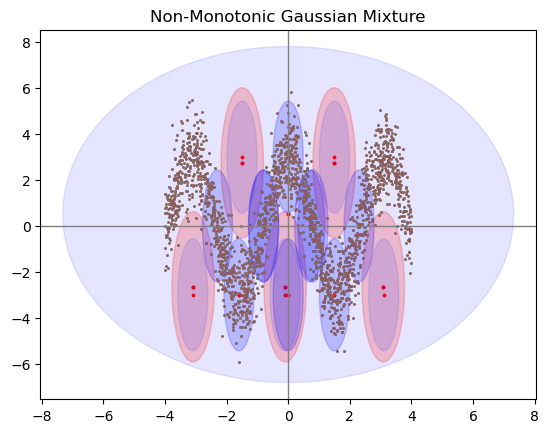

In [67]:
from scipy.special import softmax

_, ax = plt.subplots()
x, y = features[:,0], features[:,1]

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

for i in range(len(recomputed_params['means'])):
    sigma = recomputed_params['sigmas'][i]
    mu = recomputed_params['means'][i]
    
    color = 'red' if recomputed_params['weights'][i] < 0 else 'blue' 
    norm_weigths = softmax(recomputed_params['weights'])

    config = {
        'edgecolor': color,
        'facecolor': color,
        'alpha': 0.1
    }

    _confidence_ellipse(ax, sigma, mu, **config)
    ax.scatter(mu[0], mu[1], c='red', s=3)
    ax.scatter(x, y, s=0.05)

ax.set_title('Non-Monotonic Gaussian Mixture')